In [2]:
from qiskit import QuantumCircuit
from qiskit import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

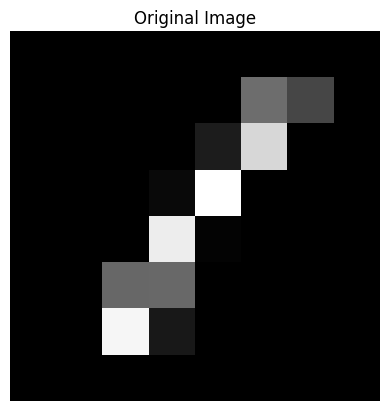

In [3]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('mnist-resized neqr.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [4]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_vals):
    n = len(position_qubits)
    m = len(intensity_qubits)

    for idx, pixel in enumerate(pixel_vals):
        # big-endian index & intensity strings
        bin_idx       = format(idx,   f'0{n}b')  
        intensity_bin = format(pixel, f'0{m}b')

        # 1) “select” the basis state |idx⟩ by flipping pos-qubits where bit=0
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])

        # 2) for each ‘1’ in the intensity, apply an mcx onto the reversed qubit
        for j, bit in enumerate(intensity_bin):
            if bit == '1':
                circ.mcx(
                    control_qubits=position_qubits,
                    target_qubit=intensity_qubits[m - 1 - j]
                )

        # 3) uncompute the X’s so the pos-register is clean for the next idx
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
# qc.draw('mpl')

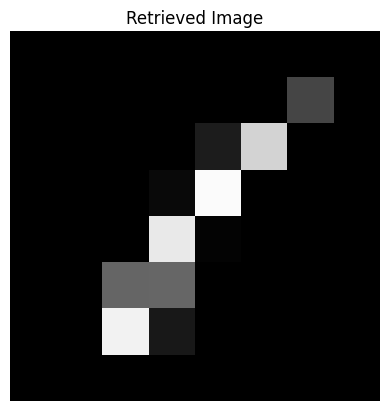

In [5]:
from collections import defaultdict
from qiskit import transpile
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1) Transpile & run
simulator = AerSimulator()
t_qc = transpile(qc, simulator)
result = simulator.run(t_qc, shots=150).result()
counts = result.get_counts()

# 2) Build a dict: position → { intensity → votes }
pos2counts = defaultdict(lambda: defaultdict(int))
for bitstr, cnt in counts.items():
    # MSB-first: first 8 bits = intensity, last 6 bits = position
    intensity = int(bitstr[:8],  2)
    position  = int(bitstr[8:],   2)
    pos2counts[position][intensity] += cnt

# 3) Winner-takes-all decode
flat = np.zeros(64, dtype=int)
for pos, idict in pos2counts.items():
    # pick the intensity with the highest vote-count
    flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]

# 4) Reshape back to 8×8 and plot
retrieve_image = flat.reshape((8,8)).astype(np.uint8)
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()


In [6]:
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np

# 1) Flatten & normalize the original image
original_flat = image.flatten().astype(float)
orig_norm     = original_flat / np.linalg.norm(original_flat)

# 2) Flatten & normalize the retrieved image
retrieved_flat = retrieve_image.flatten().astype(float)
retrieved_norm = retrieved_flat / np.linalg.norm(retrieved_flat)

# 3) Build statevectors
original_state  = Statevector(orig_norm)
retrieved_state = Statevector(retrieved_norm)

# 4) Compute fidelity
fidelity = state_fidelity(original_state, retrieved_state)
print(f"Quantum state fidelity between original and retrieved images: {fidelity:.4f}")


Quantum state fidelity between original and retrieved images: 0.9557


In [10]:
from analysis import balanced_weighted_mae, ssim, mae

bal_mae = balanced_weighted_mae(image, retrieve_image)
mae_val = mae(image, retrieve_image)
ssim_val = ssim(image, retrieve_image)

print(f"Balanced MAE Fidelity: {bal_mae}")
print(f"MAE Fidelity: {mae_val}")
print(f"SSIM: {ssim_val}")

Balanced MAE Fidelity: 0.9650326780974865
MAE Fidelity: 0.9934436082839966
SSIM: 0.9711674827561264
